# Predicting MLB Salaries

## Exploratory Data Analysis

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import explained_variance_score

import statsmodels.formula.api as smf

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

Import the batting, pitching and salary data. The data comes from the Lahman Baseball Database. http://www.seanlahman.com/baseball-database.html

In [4]:
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
salaries = pd.read_csv('Salaries.csv')

In [5]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


In [6]:
batting.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102392.000000,101516.000000,79360.000000,102816.000000,94978.000000,66251.000000,100006.000000,96478.000000,66782.000000,76706.000000
mean,1964.262313,1.077838,51.343439,141.905511,18.815544,37.139930,6.289167,1.293252,2.813599,17.003975,2.976821,1.226008,13.067207,20.529712,1.105870,1.056057,2.299540,1.054101,2.981018
std,38.856297,0.284366,47.121658,184.654492,28.242983,52.603757,9.662468,2.645770,6.304919,26.352011,7.717174,2.747377,20.746460,28.328542,2.780187,2.276251,4.241095,1.961732,4.735153
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1934.000000,1.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,1.000000,34.000000,49.000000,4.000000,9.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,1.000000,80.000000,231.000000,27.000000,58.000000,9.000000,1.000000,2.000000,24.000000,2.000000,1.000000,18.000000,29.000000,1.000000,1.000000,3.000000,1.000000,4.000000
max,2016.000000,5.000000,165.000000,716.000000,192.000000,262.000000,67.000000,36.000000,73.000000,191.000000,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000


Below is a description of the variables in the batting data frame. It is a data frame with 102816 observations on 22 variables.
- playerID Player ID code
- yearID Year
- stint player’s stint (order of appearances within a season)
- teamID Team; a factor
- lgID League; a factor with levels AA AL FL NL PL UA
- G Games: number of games in which a player played
- AB At Bats
- R Runs
- H Hits: times reached base because of a batted, fair ball without error by the defense
- 2B Doubles: hits on which the batter reached second base safely
- 3B Triples: hits on which the batter reached third base safely
- HR Homeruns
- RBI Runs Batted In
- SB Stolen Bases
- CS Caught Stealing
- BB Base on Balls
- SO Strikeouts
- IBB Intentional walks
- HBP Hit by pitch
- SH Sacrifice hits
- SF Sacrifice flies
- GIDP Grounded into double plays

In [7]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [8]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,...,30388.000000,44830.000000,44405.000000,44963.000000,44724.000000,44830.000000,44963.000000,12063.000000,12063.000000,12061.000000
mean,1968.670062,1.079643,4.715744,4.715722,23.681761,9.485488,3.151035,0.448591,1.504793,253.872139,...,2.411379,2.528575,2.266096,0.301604,343.312181,6.345260,43.021773,2.141922,1.878388,5.322610
std,37.569499,0.284834,5.813410,4.988846,18.493488,12.283920,7.081844,1.109742,4.991518,257.330446,...,2.772648,3.425706,2.998881,0.755523,348.758261,9.993949,43.245812,2.710191,2.121352,5.990178
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1941.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,64.000000,0.000000,11.000000,0.000000,0.000000,1.000000
50%,1978.000000,1.000000,2.000000,3.000000,21.000000,3.000000,0.000000,0.000000,0.000000,167.000000,...,2.000000,1.000000,1.000000,0.000000,227.000000,3.000000,28.000000,1.000000,1.000000,3.000000
75%,2001.000000,1.000000,7.000000,8.000000,35.000000,17.000000,3.000000,0.000000,1.000000,393.000000,...,4.000000,4.000000,3.000000,0.000000,535.000000,8.000000,67.000000,3.000000,3.000000,8.000000
max,2016.000000,4.000000,59.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,...,23.000000,63.000000,41.000000,16.000000,2906.000000,84.000000,519.000000,21.000000,14.000000,40.000000


Pitching: A data frame with 44963 observations on the following 30 variables.
- playerID Player ID code
- yearID Year
- stint player’s stint (order of appearances within a season)
- teamID Team; a factor
- lgID League; a factor with levels AA AL FL NL PL UA
- W Wins
- L Losses
- G Games
- GS Games Started
- CG Complete Games
- SHO Shutouts
- SV Saves
- IPouts Outs Pitched (innings pitched x 3)
- H Hits
- ER Earned Runs
- HR Homeruns
- BB Walks
- SO Strikeouts
- BAOpp Opponent’s Batting Average
- ERA Earned Run Average
- IBB Intentional Walks
- WP Wild Pitches
- HBP Batters Hit By Pitch
- BK Balks
- BFP Batters faced by Pitcher
- GF Games Finished
- R Runs Allowed
- SH Sacrifices by opposing batters
- SF Sacrifice flies by opposing batters
- GIDP Grounded into double plays by opposing batter

In [9]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


Drop the years before 1985.  Salary data not available.

In [10]:
batting_1985 = batting[batting.yearID > 1984]
pitching_1985 = pitching[pitching.yearID > 1984]

In [11]:
batting_1985.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000
mean,2001.524657,1.081770,50.906647,123.737068,16.515045,32.355497,6.228085,0.700693,3.575868,15.648742,2.358849,1.015920,11.900288,23.642581,0.973310,1.101831,1.217389,1.026222,2.777411
std,9.085021,0.287192,46.107731,181.238290,27.029322,50.721758,10.234521,1.626015,7.372347,26.539534,6.542026,2.348021,20.513077,34.268786,2.719686,2.443462,2.447796,1.959216,4.693949
min,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,1.000000,34.000000,22.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2009.000000,1.000000,75.000000,189.000000,22.000000,47.000000,9.000000,1.000000,3.000000,21.000000,1.000000,1.000000,16.000000,35.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,2016.000000,4.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,110.000000,29.000000,232.000000,223.000000,120.000000,35.000000,39.000000,17.000000,35.000000


In [12]:
pitching_1985.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,...,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,12063.000000,12063.000000,12061.000000
mean,2002.025872,1.084622,3.672522,3.672522,26.090127,7.347145,0.436121,0.141771,1.852625,196.889756,...,1.976280,2.383676,2.237152,0.348947,282.248261,6.911024,33.533604,2.141922,1.878388,5.322610
std,9.036945,0.289777,4.433829,3.839559,20.406921,11.094134,1.395408,0.521453,6.551777,190.060773,...,2.301131,2.766560,2.694288,0.860614,266.642048,11.518385,31.189015,2.710191,2.121352,5.990178
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1995.000000,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,48.000000,...,0.000000,0.000000,0.000000,0.000000,73.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,2003.000000,1.000000,2.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,139.000000,...,1.000000,2.000000,1.000000,0.000000,202.000000,2.000000,23.000000,1.000000,1.000000,3.000000
75%,2010.000000,1.000000,5.000000,6.000000,35.000000,12.000000,0.000000,0.000000,0.000000,265.000000,...,3.000000,4.000000,3.000000,0.000000,380.000000,9.000000,47.000000,3.000000,3.000000,8.000000
max,2016.000000,4.000000,27.000000,21.000000,94.000000,40.000000,20.000000,10.000000,62.000000,856.000000,...,18.000000,26.000000,21.000000,16.000000,1231.000000,79.000000,160.000000,21.000000,14.000000,40.000000


Delete the fielding players that have less than 100 games.  We want to throw out players who are injured. 

In [13]:
batting_1985_100g = batting_1985[batting_1985.G >= 100]


In [14]:
batting_1985_100g.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000
mean,2000.850803,1.004991,133.641306,460.452583,65.339404,125.965331,24.393093,2.785377,14.823688,62.255632,9.767301,4.033320,46.570080,81.405909,4.193174,4.209227,2.568056,4.020370,10.441117
std,9.185847,0.074207,18.525777,115.207988,24.334992,38.296878,9.491628,2.602241,10.551384,27.106037,11.836364,3.797469,23.021849,33.154159,4.935326,3.881065,3.471900,2.542725,5.263401
min,1985.000000,1.000000,100.000000,95.000000,7.000000,18.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,1.000000,117.000000,382.000000,47.000000,98.000000,18.000000,1.000000,7.000000,42.000000,2.000000,1.000000,30.000000,57.000000,1.000000,1.000000,0.000000,2.000000,7.000000
50%,2001.000000,1.000000,136.000000,472.000000,64.000000,127.000000,24.000000,2.000000,13.000000,59.000000,5.000000,3.000000,43.000000,78.000000,3.000000,3.000000,1.000000,4.000000,10.000000
75%,2009.000000,1.000000,150.000000,554.000000,83.000000,155.000000,31.000000,4.000000,21.000000,81.000000,13.000000,6.000000,59.000000,102.000000,6.000000,6.000000,4.000000,5.000000,14.000000
max,2016.000000,3.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,110.000000,29.000000,232.000000,223.000000,120.000000,35.000000,39.000000,17.000000,35.000000


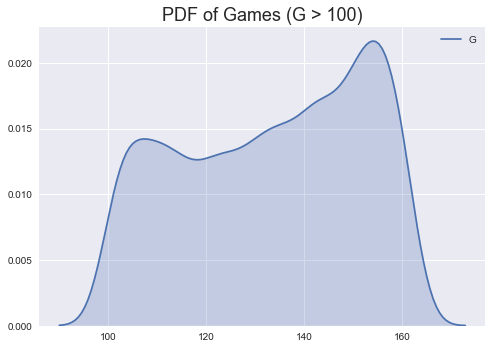

In [15]:
sns.kdeplot(batting_1985_100g.G, shade=True)
plt.title("PDF of Games (G > 100)")
plt.show()

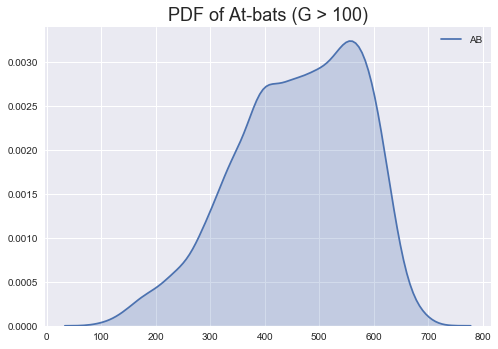

In [16]:
sns.kdeplot(batting_1985_100g.AB, shade=True)
plt.title("PDF of At-bats (G > 100)")
plt.show()

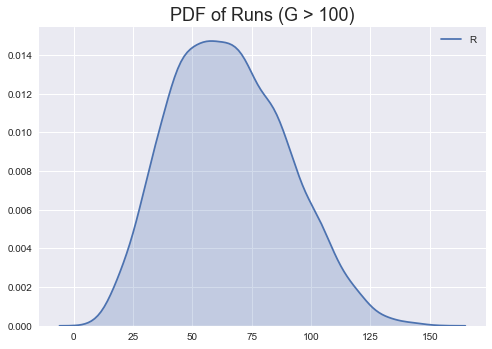

In [17]:
sns.kdeplot(batting_1985_100g.R, shade=True)
plt.title("PDF of Runs (G > 100)")
plt.show()

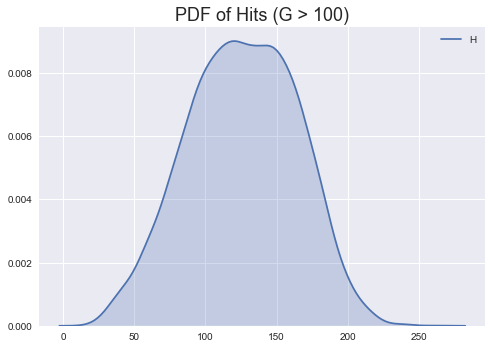

In [18]:
sns.kdeplot(batting_1985_100g.H, shade=True)
plt.title("PDF of Hits (G > 100)")
plt.show()

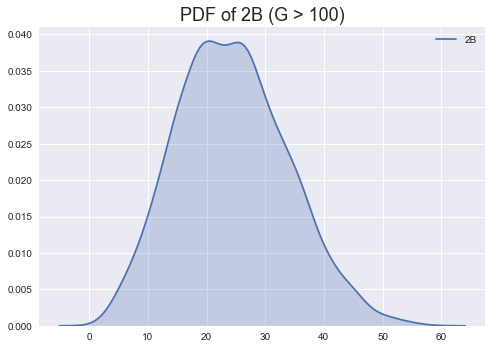

In [19]:
sns.kdeplot(batting_1985_100g['2B'], shade=True)
plt.title("PDF of 2B (G > 100)")
plt.show()

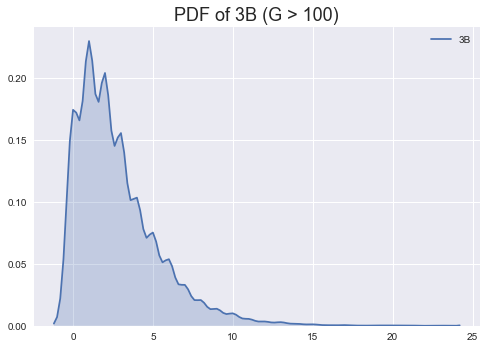

In [20]:
sns.kdeplot(batting_1985_100g['3B'], shade=True)
plt.title("PDF of 3B (G > 100)")
plt.show()

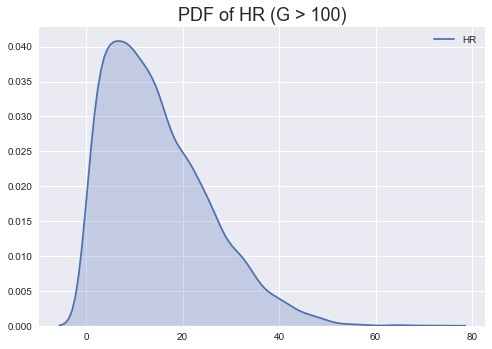

In [21]:
sns.kdeplot(batting_1985_100g.HR, shade=True)
plt.title("PDF of HR (G > 100)")
plt.show()

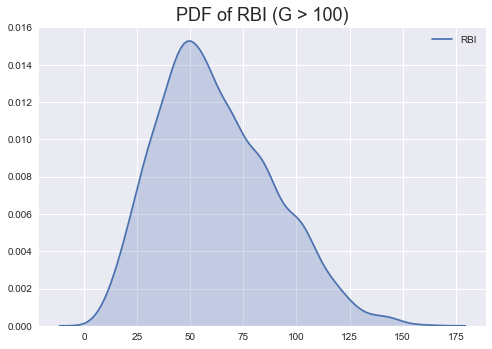

In [22]:
sns.kdeplot(batting_1985_100g.RBI, shade=True)
plt.title("PDF of RBI (G > 100)")
plt.show()

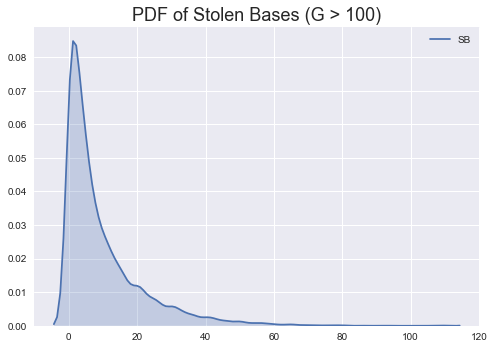

In [23]:
sns.kdeplot(batting_1985_100g.SB, shade=True)
plt.title("PDF of Stolen Bases (G > 100)")
plt.show()

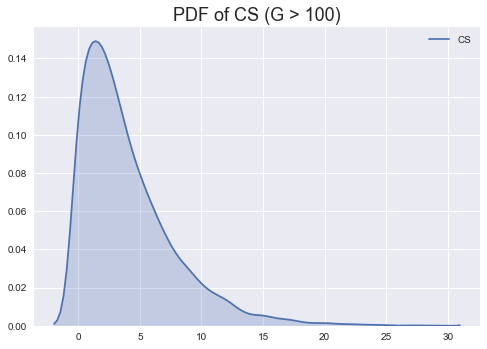

In [24]:
sns.kdeplot(batting_1985_100g.CS, shade=True)
plt.title("PDF of CS (G > 100)")
plt.show()

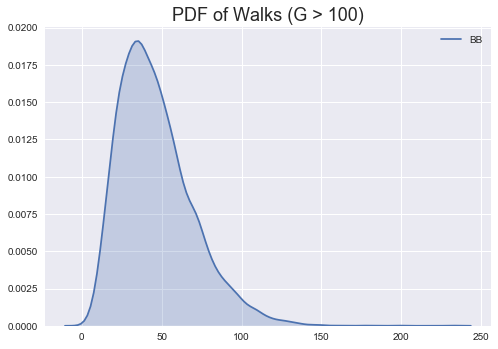

In [25]:
sns.kdeplot(batting_1985_100g.BB, shade=True)
plt.title("PDF of Walks (G > 100)")
plt.show()

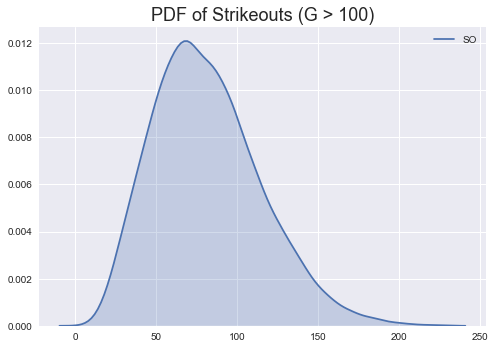

In [26]:
sns.kdeplot(batting_1985_100g.SO, shade=True)
plt.title("PDF of Strikeouts (G > 100)")
plt.show()

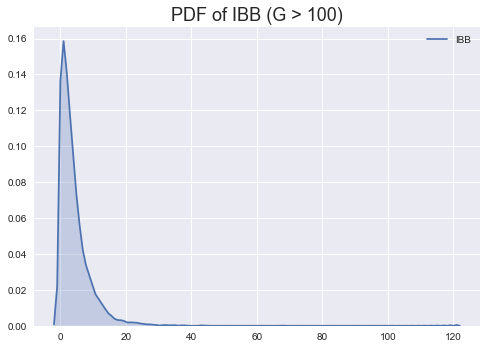

In [27]:
sns.kdeplot(batting_1985_100g.IBB, shade=True)
plt.title("PDF of IBB (G > 100)")
plt.show()

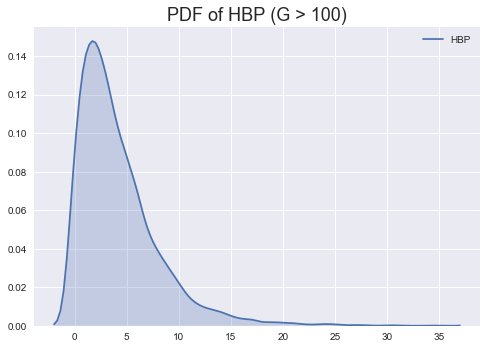

In [28]:
sns.kdeplot(batting_1985_100g.HBP, shade=True)
plt.title("PDF of HBP (G > 100)")
plt.show()

In [29]:
df = pd.merge(salaries, batting_1985_100g)

In [30]:
df.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,21.0,0.0,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0
1,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,72.0,9.0,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0
2,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,89.0,1.0,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0
3,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,39.0,4.0,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0
4,1985,ATL,NL,murphda05,1625000,1,162,616,118,185,...,111.0,10.0,3.0,90,141.0,15.0,1.0,0.0,5.0,14.0


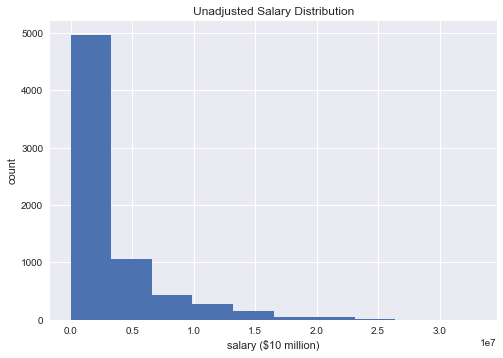

In [31]:
sns.set()
_ = plt.hist(df.salary)
plt.xlabel('salary ($10 million)')
plt.ylabel('count')
plt.title('Unadjusted Salary Distribution')
plt.show()

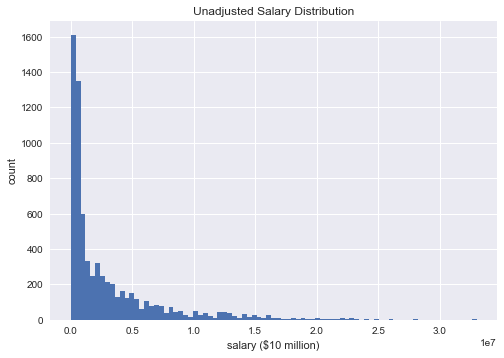

In [32]:
n_data = len(df.salary)
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)
_ = plt.hist(df.salary, bins = n_bins)
_ = plt.xlabel('salary ($10 million)')
_ = plt.ylabel('count')
_ = plt.title('Unadjusted Salary Distribution')
plt.show()

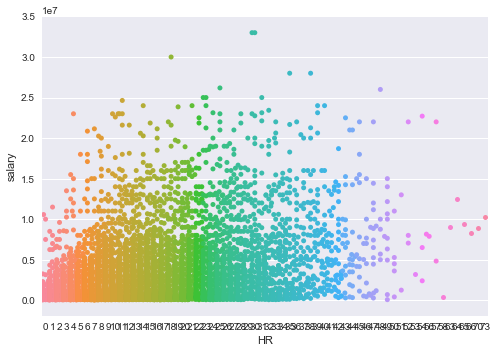

In [33]:
sns.swarmplot(x='HR', y='salary', data = df)
plt.show()

Plot unadjusted salary over time for the years 1985 - 2016.  Unadjusted salary is salary that is not adjusted for inflation, or is in nominal dollars.

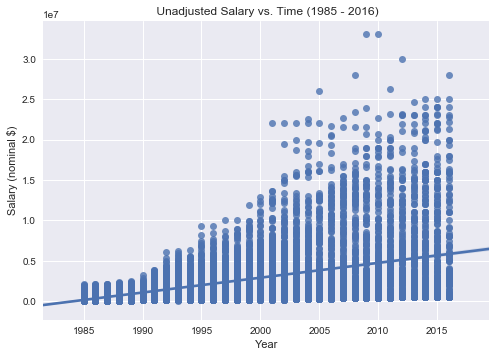

In [34]:
sns.regplot(x='yearID',
            y='salary',
           data=df)
plt.title(' Unadjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (nominal $)')
plt.show()

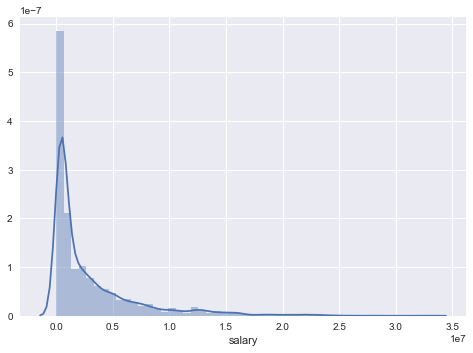

In [35]:
sns.distplot(df.salary)
plt.show()

There are rows that have zeros for the salary.  Remove these observations.  The lowest minimum salary in current year dollars was in 1985.  It was 60,000.  Remove the observations where the salary is less than 60,000.

In [36]:
df_clean1 = df[df.salary !=0]
df_clean2 = df_clean1[df_clean1.salary >= 60000]
df_clean2.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,21.0,0.0,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0
1,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,72.0,9.0,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0
2,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,89.0,1.0,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0
3,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,39.0,4.0,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0
4,1985,ATL,NL,murphda05,1625000,1,162,616,118,185,...,111.0,10.0,3.0,90,141.0,15.0,1.0,0.0,5.0,14.0


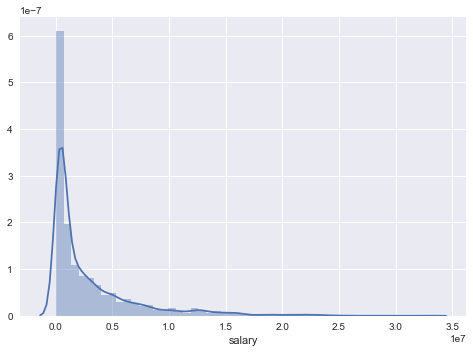

In [37]:
sns.distplot(df_clean2.salary)
plt.show()

Need to adjust salary for inflation.  For ease of interpretation, let's use 2016 dollars.  Use the CPI to calculate this.

In [38]:
cpi = pd.read_csv('CPI.csv')
cpi.head()

,yearID,CPI
0,1985,107.6
1,1986,109.6
2,1987,113.6
3,1988,118.3
4,1989,124.0


Merge the salary data and cpi data by year.  Use the CPI value to adjust salary to 2016 dollars.

In [39]:
salary_adj = pd.merge(df_clean2, cpi, how='left', on='yearID')
salary_adj.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,CPI
0,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,0.0,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0,107.6
1,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,9.0,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0,107.6
2,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,1.0,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0,107.6
3,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,4.0,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0,107.6
4,1985,ATL,NL,murphda05,1625000,1,162,616,118,185,...,10.0,3.0,90,141.0,15.0,1.0,0.0,5.0,14.0,107.6


In [40]:
salary_adj['salary2016'] = (240/salary_adj.CPI)*salary_adj.salary
salary_adj.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,CPI,salary2016
0,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0,107.6,1.784387e+06
1,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0,107.6,5.576208e+05
2,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0,107.6,3.345725e+06
3,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0,107.6,1.014870e+06
4,1985,ATL,NL,murphda05,1625000,1,162,616,118,185,...,3.0,90,141.0,15.0,1.0,0.0,5.0,14.0,107.6,3.624535e+06


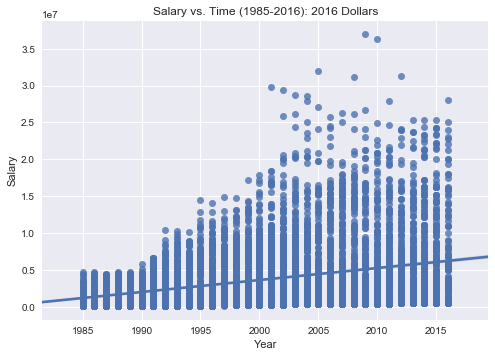

In [41]:
sns.regplot(x='yearID',
            y='salary2016',
            data=salary_adj)
plt.title('Salary vs. Time (1985-2016): 2016 Dollars')
plt.ylabel('Salary')
plt.xlabel('Year')
plt.show()

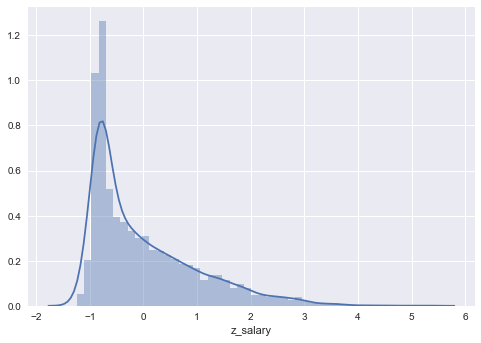

In [42]:
salary_adj['mean_salary'] = salary_adj['salary2016'].groupby(salary_adj['yearID']).transform('mean')
salary_adj['std_salary'] = salary_adj['salary2016'].groupby(salary_adj['yearID']).transform('std')
salary_adj.head()

salary_adj['z_salary'] = (salary_adj.salary2016 - salary_adj.mean_salary)/salary_adj.std_salary
salary_adj.head()

# plot z-scores for salary distribution
sns.distplot(salary_adj.z_salary)
plt.show()

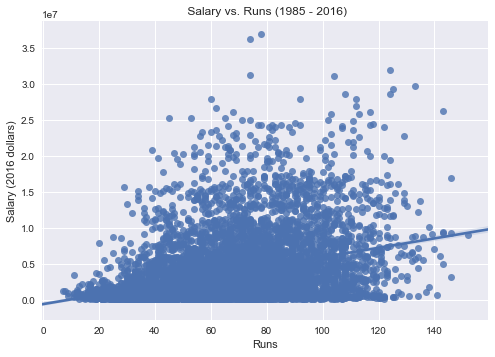

In [43]:
sns.regplot(x='R',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Runs (1985 - 2016)')
plt.xlabel('Runs')
plt.ylabel('Salary (2016 dollars)')
plt.show()

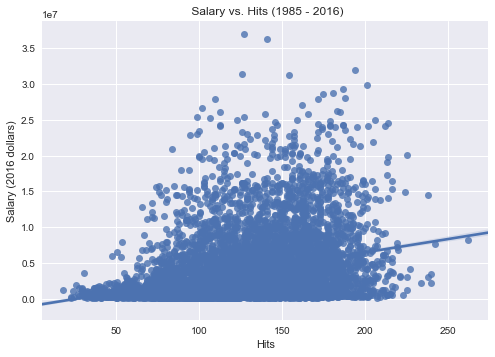

In [44]:
sns.regplot(x='H',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Hits (1985 - 2016)')
plt.xlabel('Hits')
plt.ylabel('Salary (2016 dollars)')
plt.show()

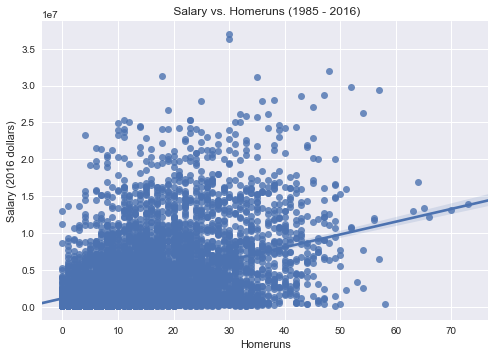

In [45]:
sns.regplot(x='HR',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Homeruns (1985 - 2016)')
plt.xlabel('Homeruns')
plt.ylabel('Salary (2016 dollars)')
plt.show()

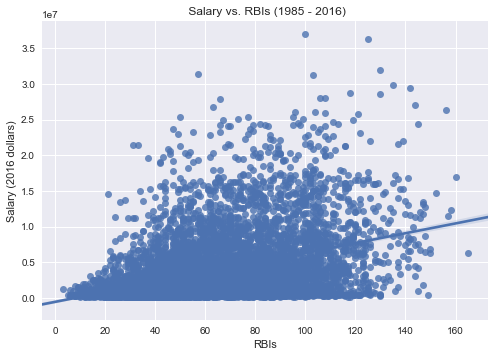

In [46]:
sns.regplot(x='RBI',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. RBIs (1985 - 2016)')
plt.xlabel('RBIs')
plt.ylabel('Salary (2016 dollars)')
plt.show()

## Regression Models

In [47]:
salary_adj = pd.DataFrame(salary_adj)
salary_adj.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,IBB,HBP,SH,SF,GIDP,CPI,salary2016,mean_salary,std_salary,z_salary
0,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,4.0,0.0,0.0,1.0,5.0,107.6,1.784387e+06,1.261677e+06,913318.087782,0.572319
1,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,4.0,3.0,1.0,2.0,13.0,107.6,5.576208e+05,1.261677e+06,913318.087782,-0.770877
2,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,4.0,1.0,0.0,6.0,18.0,107.6,3.345725e+06,1.261677e+06,913318.087782,2.281842
3,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,2.0,4.0,7.0,6.0,11.0,107.6,1.014870e+06,1.261677e+06,913318.087782,-0.270231
4,1985,ATL,NL,murphda05,1625000,1,162,616,118,185,...,15.0,1.0,0.0,5.0,14.0,107.6,3.624535e+06,1.261677e+06,913318.087782,2.587114


Create a batting average feature, which is simply the number hits a player has divided by the number of at-bats.  Also, create the log of salary.

In [48]:
salary_adj['AVG'] = salary_adj.H / salary_adj.AB *1000
salary_adj['log_salary2016'] = np.log(salary_adj['salary2016'])
salary_adj.head()
salary_adj.describe()

,yearID,salary,stint,G,AB,R,H,2B,3B,HR,...,SH,SF,GIDP,CPI,salary2016,mean_salary,std_salary,z_salary,AVG,log_salary2016
count,7016.000000,7.016000e+03,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,...,7016.000000,7016.000000,7016.000000,7016.000000,7.016000e+03,7.016000e+03,7.016000e+03,7.016000e+03,7016.000000,7016.000000
mean,2000.660633,3.023212e+06,1.000143,134.221921,463.657070,65.898803,127.006271,24.640964,2.774800,14.990593,...,2.573831,4.076539,10.559008,176.594555,3.774645e+06,3.774645e+06,4.052609e+06,-7.912080e-18,271.035221,14.376306
std,9.036609,4.178157e+06,0.011939,18.417350,114.744531,24.482476,38.290628,9.497755,2.612765,10.633929,...,3.488577,2.551980,5.271578,40.387984,4.711320e+06,1.520582e+06,1.883666e+06,9.977880e-01,29.823492,1.312842
min,1985.000000,6.000000e+04,1.000000,100.000000,95.000000,7.000000,18.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,107.600000,1.267963e+05,1.216416e+06,9.133181e+05,-1.245297e+00,150.000000,11.750337
25%,1993.000000,4.140000e+05,1.000000,118.000000,385.000000,47.000000,99.000000,18.000000,1.000000,7.000000,...,0.000000,2.000000,7.000000,144.500000,5.131531e+05,2.492804e+06,2.481645e+06,-7.798945e-01,250.753032,13.148330
50%,2001.000000,1.142446e+06,1.000000,136.500000,476.000000,65.000000,128.000000,24.000000,2.000000,13.000000,...,1.000000,4.000000,10.000000,177.100000,1.804317e+06,4.539357e+06,4.824848e+06,-3.503367e-01,270.526895,14.405693
75%,2008.000000,4.000000e+06,1.000000,151.000000,557.000000,83.000000,156.000000,31.000000,4.000000,21.000000,...,4.000000,6.000000,14.000000,214.500000,5.217391e+06,5.058252e+06,5.671143e+06,5.327253e-01,290.532406,15.467508
max,2016.000000,3.300000e+07,2.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,...,39.000000,17.000000,35.000000,240.000000,3.692308e+07,5.875635e+06,6.659991e+06,5.269274e+00,393.794749,17.424347


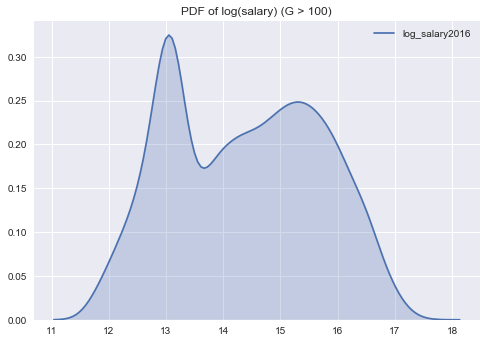

In [49]:
sns.kdeplot(salary_adj.log_salary2016, shade=True)
plt.title("PDF of log(salary) (G > 100)")
plt.show()

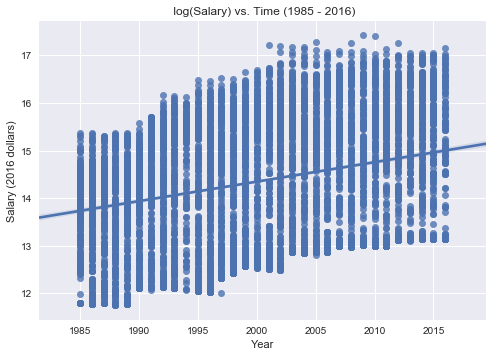

In [50]:
sns.regplot(x='yearID',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (2016 dollars)')
plt.show()

In [51]:
list(salary_adj)

['yearID',
 'teamID',
 'lgID',
 'playerID',
 'salary',
 'stint',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'IBB',
 'HBP',
 'SH',
 'SF',
 'GIDP',
 'CPI',
 'salary2016',
 'mean_salary',
 'std_salary',
 'z_salary',
 'AVG',
 'log_salary2016']

In [52]:
y = salary_adj.salary2016
x = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF',
               'GIDP', 'AVG']]

Create the training and test splits.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [54]:
X_train.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,AVG
4999,161,612,105,189,45,0,27,89.0,6.0,3.0,47,119.0,3.0,19.0,2.0,4.0,18.0,308.823529
4192,122,177,25,47,12,2,9,40.0,1.0,0.0,32,51.0,2.0,2.0,0.0,4.0,2.0,265.536723
30,150,460,37,114,17,0,5,55.0,1.0,2.0,37,35.0,2.0,3.0,16.0,4.0,12.0,247.826087
995,100,330,42,93,20,4,9,49.0,1.0,4.0,32,39.0,5.0,1.0,0.0,5.0,8.0,281.818182
4968,128,418,49,114,31,2,13,65.0,5.0,0.0,41,79.0,2.0,1.0,1.0,5.0,9.0,272.727273


In [55]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [56]:
predictions = lm.predict(X_test)

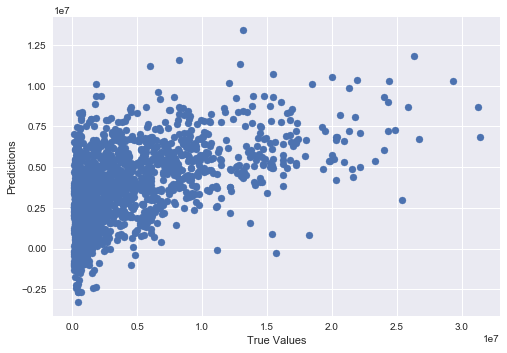

In [57]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [58]:
print("Score:", model.score(X_test, y_test))

Score: 0.261873550564


In [59]:
model.coef_



array([ -69097.45183992,    4002.80128984,   21035.1112786 ,
         44729.94602258,  -38436.25139161, -220340.80196302,
         64574.253577  ,   -7892.03585894,   35999.28613827,
       -189686.02899041,   27027.87681009,   -6470.76939847,
         92008.65654343,   64314.81900423,  -93742.40409409,
         16612.23494369,   74382.39463318,  -21252.27183285])

## XGBoost Models

In [60]:
# First XGBoost model for Batting Salary dataset

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model_xgb = XGBRegressor(objective='reg:linear',
                         n_estimators=50,
                         max_depth=4,
                         learning_rate = 0.05,
                         nthreads=4,
                         seed=123)
model_xgb.fit(X_train, y_train)
# make predictions for test data
y_pred = model_xgb.predict(X_test)
print("Score_XGB:", model_xgb.score(X_test, y_test))

Score_XGB: 0.247082176304


In [62]:
 import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 500),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(objective='reg:linear', nthreads=-1)  

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)
gs.best_score_

0.27061159564535897

## Panel Data Models using linearmodels

In [86]:
import linearmodels
from pandas import DataFrame
salary_adj = pd.DataFrame(salary_adj)
panel_df = salary_adj.sort_values(["playerID", "yearID"])

panel_df = panel_df.set_index(['playerID', 'yearID'])
panel_df

teamID lgID    salary  stint    G   AB    R    H  2B  3B  \
playerID  yearID                                                            
abbotku01 1994      FLO   NL    109000      1  101  345   41   86  17   3   
          1995      FLO   NL    119000      1  120  420   60  107  18   7   
          1996      FLO   NL    250000      1  109  320   37   81  18   7   
abercre01 2006      FLO   NL    327000      1  111  255   39   54  12   2   
abernbr01 2002      TBA   AL    215000      1  117  463   46  112  18   4   
abreubo01 1998      PHI   NL    180000      1  151  497   68  155  29   6   
          1999      PHI   NL    400000      1  152  546  118  183  35  11   
          2000      PHI   NL   2933333      1  154  576  103  182  42  10   
          2001      PHI   NL   4983000      1  162  588  118  170  48   4   
          2002      PHI   NL   6333333      1  157  572  102  176  50   6   
          2003      PHI   NL   9100000      1  158  577   99  173  35   1   
          2004      PHI   NL  10600000      1  159  574  118  173  47   1   
          2005      PHI   NL  13100000      1  162  588  104  168  37   1   
          2007      NYA   AL  15000000      1  158  605  123  171  40   5   
          2008      NYA   AL  16000000      1  156  609  100  180  39   4   
          2009      LAA   AL   5000000      1  152  563   96  165  29   3   
          2010      LAA   AL   9000000      1  154  573   88  146  41   1   
          2011      LAA   AL   9000000      1  142  502   54  127  30   1   
abreujo02 2014      CHA   AL   7000000      1  145  556   80  176  35   2   
          2015      CHA   AL   8666000      1  154  613   88  178  34   3   
ackledu01 2012      SEA   AL   2100000      1  153  607   84  137  22   2   
          2013      SEA   AL   2700000      1  113  384   40   97  18   2   
          2014      SEA   AL   1700000      1  143  502   64  123  27   4   
adamecr01 2016      COL   NL    509500      1  121  225   25   49   7   3   
adamsma01 2013      SLN   NL    490000      1  108  296   46   84  14   0   
          2014      SLN   NL    516000      1  142  527   55  152  34   5   
adamsru01 2005      TOR   AL    316000      1  139  481   68  123  27   5   
agbaybe01 1999      NYN   NL    200000      1  101  276   42   79  18   3   
          2000      NYN   NL    220000      1  119  350   59  101  19   1   
ahmedni01 2015      ARI   NL    508500      1  134  421   49   95  17   6   
...                 ...  ...       ...    ...  ...  ...  ...  ...  ..  ..   
zaungr01  2007      TOR   AL   3500000      1  110  331   43   80  24   1   
zeileto01 1990      SLN   NL    100000      1  144  495   62  121  25   3   
          1991      SLN   NL    160000      1  155  565   76  158  36   3   
          1992      SLN   NL    315000      1  126  439   51  113  18   4   
          1993      SLN   NL   1025000      1  157  571   82  158  36   1   
          1994      SLN   NL   2700000      1  113  415   62  111  25   1   
          1996      PHI   NL   2700000      1  134  500   61  134  24   0   
          1997      LAN   NL   3100000      1  160  575   89  154  17   0   
          1999      TEX   AL   3200000      1  156  588   80  172  41   1   
          2000      NYN   NL   4333333      1  153  544   67  146  36   3   
          2001      NYN   NL   6833333      1  151  531   66  141  25   1   
          2002      COL   NL   6833333      1  144  506   61  138  23   0   
          2004      NYN   NL   1000000      1  137  348   30   81  16   0   
zimmery01 2006      WAS   NL    327000      1  157  614   84  176  47   3   
          2008      WAS   NL    465000      1  106  428   51  121  24   1   
          2009      WAS   NL   3325000      1  157  610  110  178  37   3   
          2010      WAS   NL   6350000      1  142  525   85  161  32   0   
          2011      WAS   NL   9025000      1  101  395   52  114  21   2   
          2012      WAS   NL  12000000      1  145  578   93  163  36   1   
          201

In [90]:
from linearmodels import PanelOLS
lm_panel = PanelOLS(panel_df.salary2016, panel_df[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF',
               'GIDP', 'AVG']])
print(lm_panel.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             salary2016   R-squared:                        0.5496
Estimator:                   PanelOLS   R-squared (Between):              0.5939
No. Observations:                7016   R-squared (Within):               0.0460
Date:                Tue, May 15 2018   R-squared (Overall):              0.5496
Time:                        12:36:45   Log-likelihood                -1.167e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      474.38
Entities:                        1516   P-value                           0.0000
Avg Obs:                       4.6280   Distribution:                 F(18,6998)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             474.38
                            